# ST445 Managing and Visualizing Data
## Graph Visualization
### Milan Vojnovic and Christine Yuen, MT 2017
---


In this notebook, we study the activities of users across different GitHub organizations. We are going to do this by studying a representation of data as a graph. The vertices of the graph represent organizations and an edge between two vertices indicates that there is at least one user who initiated an event to at least one repository in each of the two corresponding organizations. The edge weights are defined as the number of such users. We use the data retrieved from GitHub archive for March 2nd, 2015. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Loading and manipulating data

The data processing part have been done for you. You only need to understand the code.

### Take a look at the data and extract some useful information

In [2]:
# load the data
fdate = '2015-03-02'
df = pd.read_csv(fdate + '.csv', parse_dates=['created_at'])

df.head(5)

,created_at,id,actor.login,org.login,repo.name,type
0,2015-03-02,2615962109,pdgago,simbiotica,simbiotica/charicharts,CreateEvent
1,2015-03-02,2615962111,micmania1,NaN,micmania1/silverstripe-cms,PushEvent
2,2015-03-02,2615962112,xsb,bitpay,bitpay/insight-api,WatchEvent
3,2015-03-02,2615962113,dkorolev,KnowSheet,KnowSheet/Bricks,PullRequestReviewCommentEvent
4,2015-03-02,2615962114,edwin-pers,NaN,edwin-pers/neuromancer,PushEvent


In [3]:
# looking up particular actor
df[df['actor.login']=='aaronehlers'].head(10)

,created_at,id,actor.login,org.login,repo.name,type
407349,2015-03-02 17:42:39,2617828973,aaronehlers,NaN,nagaozen/asp-xtreme-evolution,WatchEvent
407683,2015-03-02 17:43:15,2617830778,aaronehlers,NaN,mikechambers/as3corelib,WatchEvent
407957,2015-03-02 17:43:49,2617832153,aaronehlers,toursprung,toursprung/iOS-Screenshot-Automator,WatchEvent
408058,2015-03-02 17:43:59,2617832673,aaronehlers,NaN,stisti/jenkins-app,WatchEvent
408125,2015-03-02 17:44:08,2617833146,aaronehlers,NaN,dronir/SpotifyControl,WatchEvent
408174,2015-03-02 17:44:15,2617833445,aaronehlers,NaN,RobTrew/tree-tools,WatchEvent
408268,2015-03-02 17:44:27,2617833981,aaronehlers,NaN,lemonmade/templates,WatchEvent
408344,2015-03-02 17:44:36,2617834344,aaronehlers,SheetJS,SheetJS/test_files,WatchEvent
408496,2015-03-02 17:44:48,2617835109,aaronehlers,NaN,aaronfreimark/Apple-ID-AppleScript,WatchEvent
408651,2015-03-02 17:45:04,2617835886,aaronehlers,NaN,lhagan/Open-in-Chrome,WatchEvent


In [4]:
# unique event types
df['type'].unique()

array(['CreateEvent', 'PushEvent', 'WatchEvent',
       'PullRequestReviewCommentEvent', 'IssueCommentEvent',
       'PullRequestEvent', 'DeleteEvent', 'CommitCommentEvent',
       'ForkEvent', 'IssuesEvent', 'GollumEvent', 'MemberEvent',
       'ReleaseEvent', 'PublicEvent'], dtype=object)

### Transform the data to triplets: (actor, organization, repository)

In [5]:
# we consider events of any type but WatchEvent
df = df[(df['type']!='WatchEvent')]
df = df[['actor.login', 'org.login', 'repo.name']]
df = df.drop_duplicates()
df = df[df['org.login'].notnull()]
df.head(5)

,actor.login,org.login,repo.name
0,pdgago,simbiotica,simbiotica/charicharts
3,dkorolev,KnowSheet,KnowSheet/Bricks
5,dmolsen,pattern-lab,pattern-lab/patternengine-php-twig
7,LordSputnik,BookBrainz,BookBrainz/bookbrainz.org
16,ScottNZ,OpenRA,OpenRA/OpenRA


In [6]:
org_actor_df = df.groupby(['org.login', 'actor.login']).agg('count').reset_index()
org_actor_df.head(5)

,org.login,actor.login,repo.name
0,01org,117111302,1
1,01org,MCherifiOSS,1
2,01org,UIKit0,10
3,01org,askervin,1
4,01org,chivakker,1


In [7]:
org_df = org_actor_df.groupby(['org.login'])['org.login'].agg('count')
print(org_df.head())

# set of top organisations, we focus on top 100 
toporgs = org_df.sort_values(ascending=False)[:100].keys().tolist()
toporgs[:10]

org.login
01org       21
0ADMods      3
0install     1
0k           3
0x375        1
Name: org.login, dtype: int64


['mozilla',
 'apache',
 'facebook',
 'google',
 'angular',
 'docker',
 'elasticsearch',
 'iojs',
 'dotnet',
 'owncloud']

In [8]:
from itertools import combinations

actor_df = df.groupby('actor.login')

dfs = pd.DataFrame(columns=['Actor', 'Org1', 'Org2'])
for name, group in actor_df:
    orgs = group['org.login'].unique()
    orgs = [val for val in orgs if val in toporgs]
    if len(orgs)>1:
        actor_edge = pd.DataFrame(data=list(combinations(orgs, 2)), columns=['Org1', 'Org2'])
        actor_edge['Actor'] = name
        dfs = pd.concat([dfs, actor_edge])
    
dfs.head(5)

,Actor,Org1,Org2
0,1Power,mongodb,rails
0,AntouanK,iojs,npm
0,Carreau,ipython,JuliaLang
0,Dashed,babel,facebook
0,DavidA2014,atom,npm


### A check of the data before we start to create the graph

In [9]:
# check
dfs[dfs['Org2']=='Microsoft']

,Actor,Org1,Org2
0,basarat,atom,Microsoft
0,vasily-kirichenko,dotnet,Microsoft


In [10]:
dfs = dfs.groupby(['Org1', 'Org2']).agg('count').reset_index().rename(columns={'Actor': 'weight'})
dfs = dfs.sort_values(by='weight', ascending=False)
dfs.head(10)

,Org1,Org2,weight
187,odoo-dev,odoo,17
186,odoo,odoo-dev,9
133,iojs,joyent,5
105,google,GoogleCloudPlatform,5
190,openshift,GoogleCloudPlatform,4
10,GoogleCloudPlatform,openshift,4
61,chef,opscode-cookbooks,3
27,OCA,odoo,3
8,GoogleCloudPlatform,docker,3
56,babel,facebook,3


## Creating the graph

### Import the libraries

In [11]:
# importing graph visualization packages
import networkx as nx
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either PyGraphviz or pydot")

### Initialize the graph and add all the edges

In [12]:
# create the graph by adding edges one by one
G = nx.Graph()

for index, row in dfs.iterrows():
    G.add_edge(row['Org1'], row['Org2'], weight=row['weight'])

# remove isolated vertices (if any)    
remove = [node for node,degree in G.degree().items() if degree ==0]
G.remove_nodes_from(remove)

### Basic graph analysis

In [13]:
# graph size
print("graph has %d nodes with %d edges" % (nx.number_of_nodes(G), nx.number_of_edges(G)))
print(nx.number_connected_components(G), "connected components")

# connected components
gsizes = [nx.number_of_nodes(glen) for glen in nx.connected_component_subgraphs(G)]
print("G connected component sizes:", sorted(gsizes, reverse=True))

graph has 79 nodes with 232 edges
1 connected components
G connected component sizes: [79]


## Graph visualization
### Graph layout: twopi

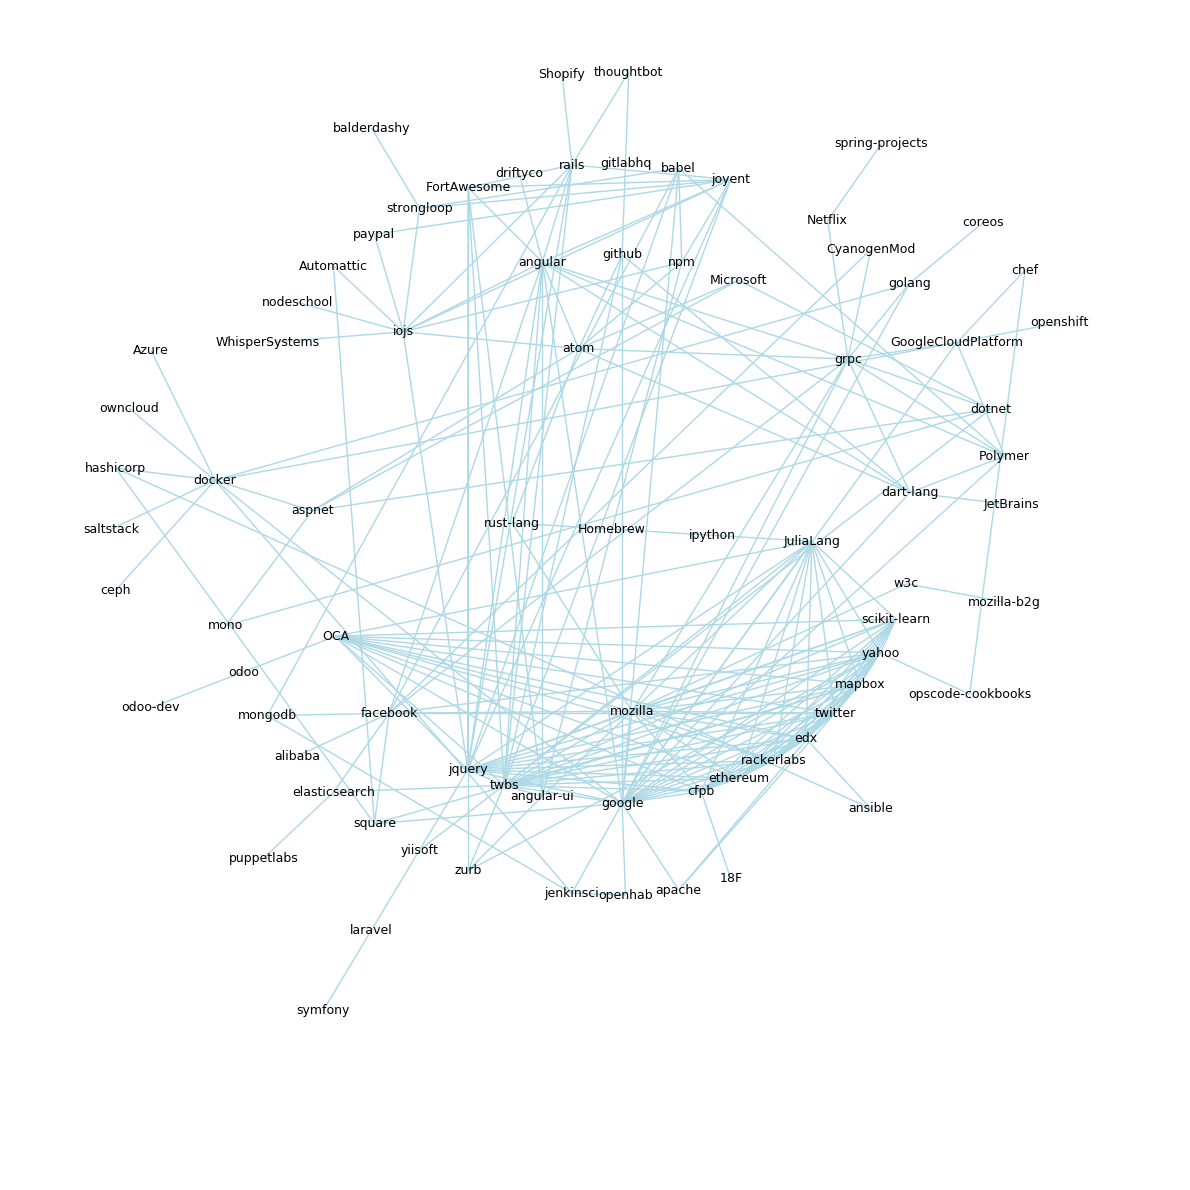

In [14]:
# add code

### Graph layout: twopi for user-defined centre node

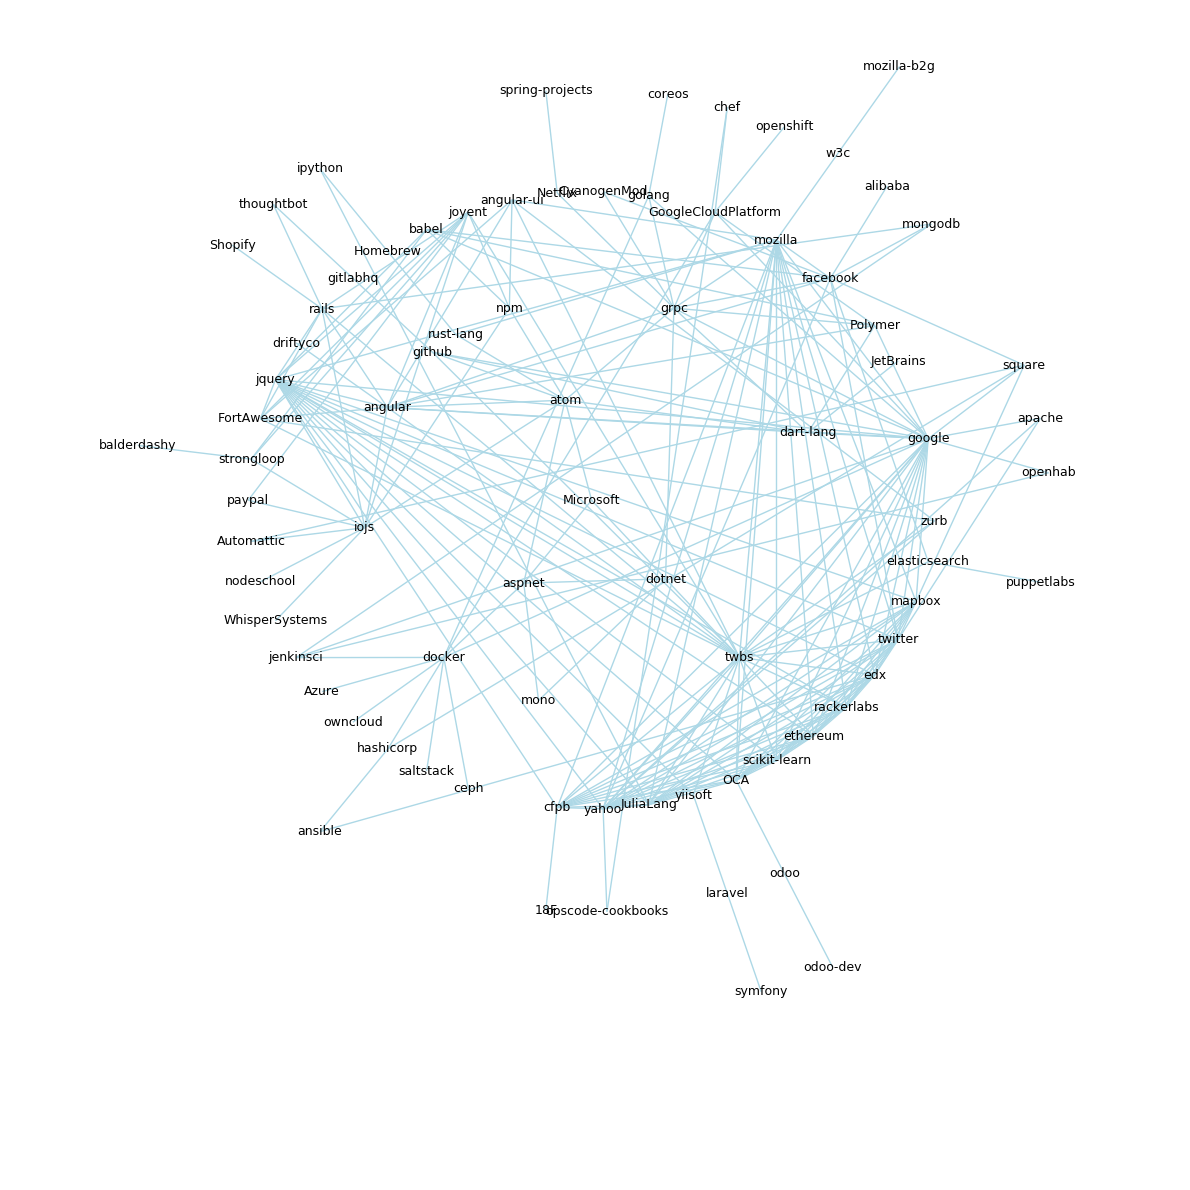

In [15]:
# add code

### Graph layout: circo

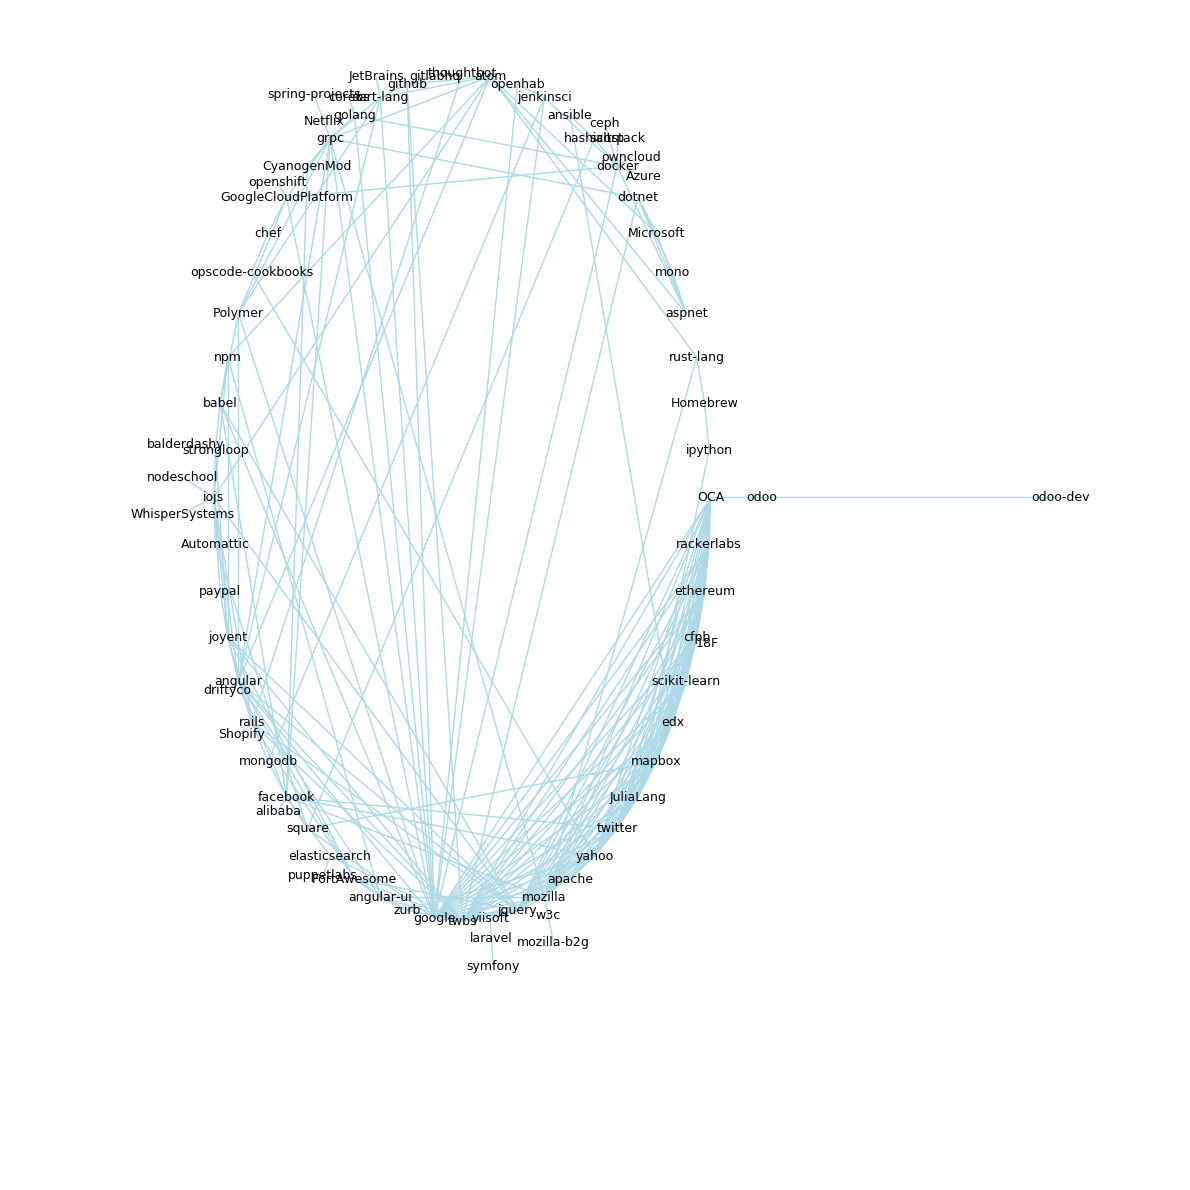

In [16]:
# add code

### Graph layout: dot

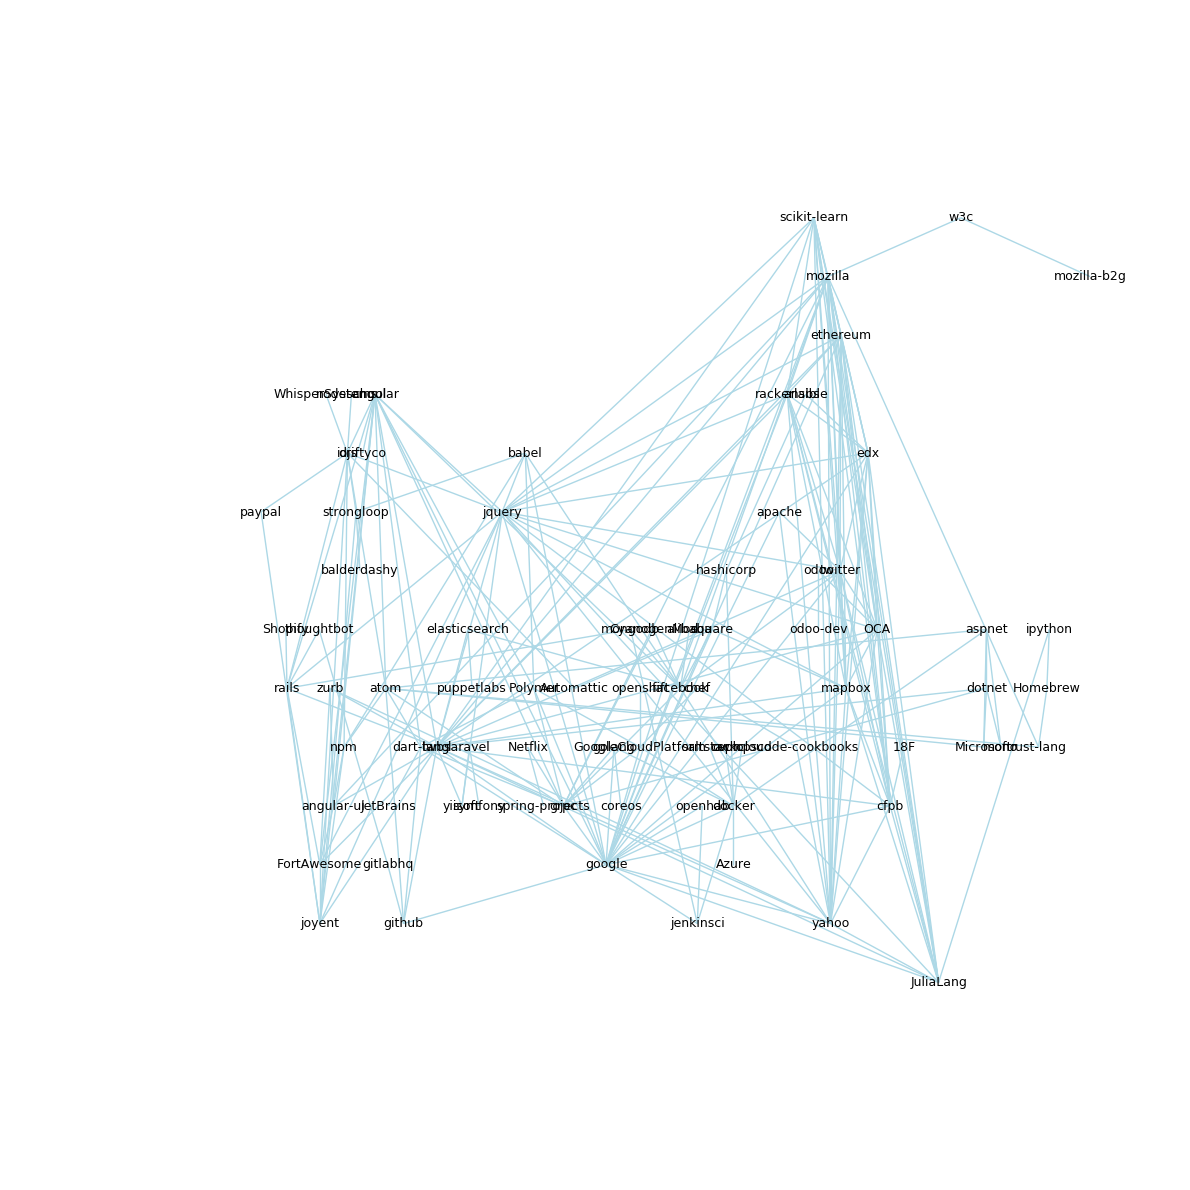

In [17]:
# add code

### Graphy layout: spring layout

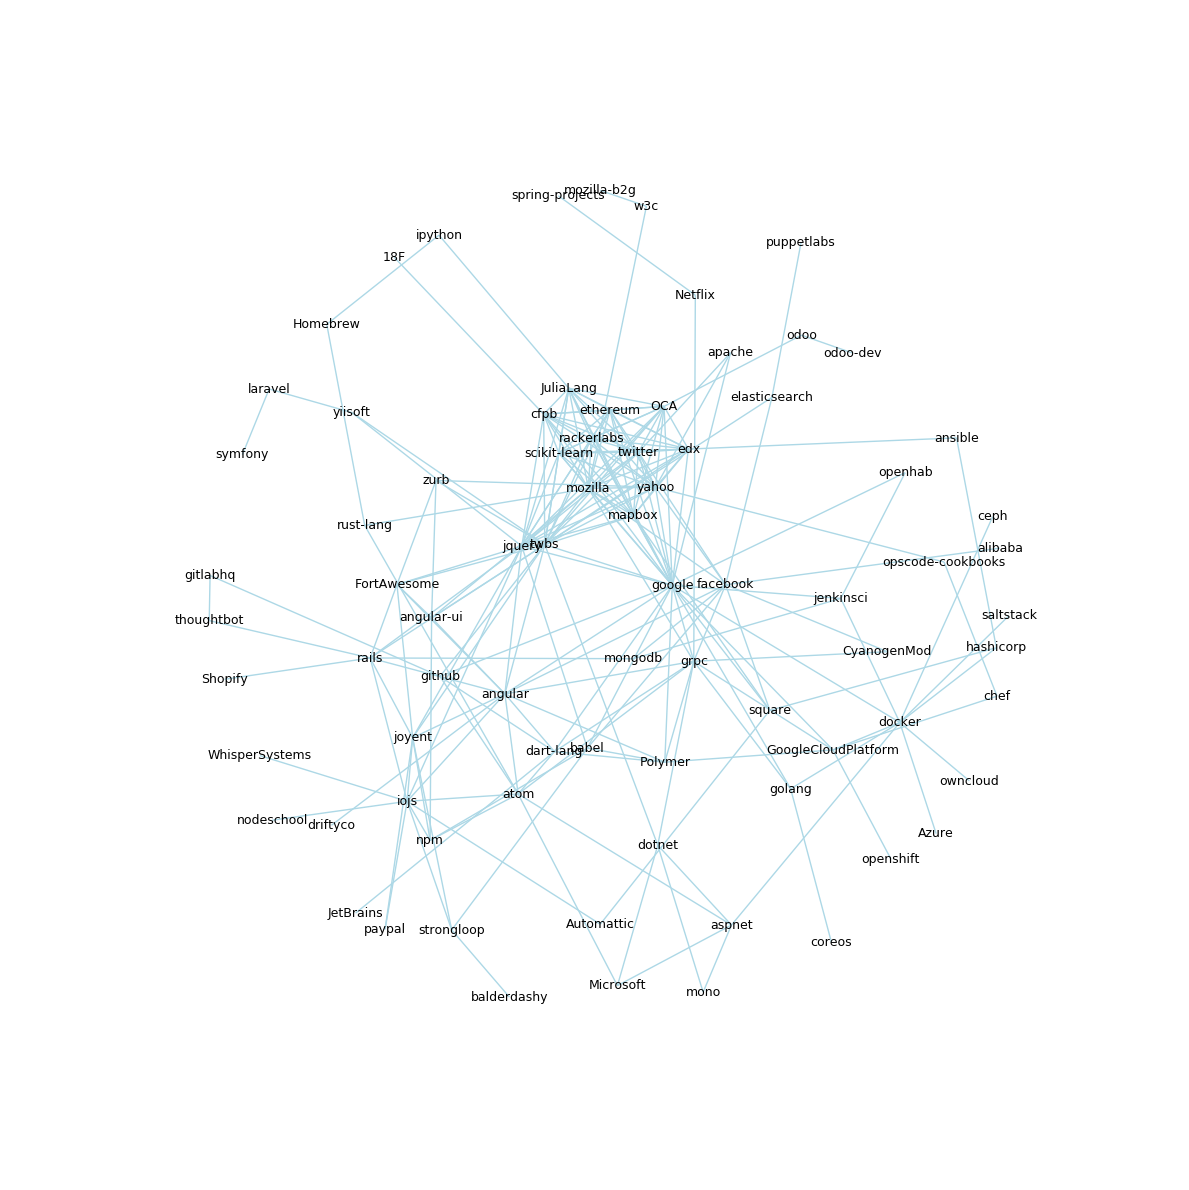

In [18]:
# add code

### Spring graphy layout vs number of iterations

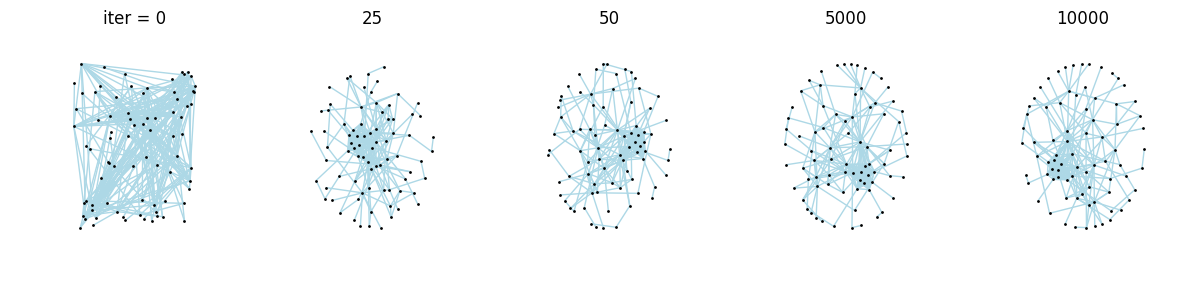

In [19]:
plt.subplots(nrows=1, ncols=5, figsize=(12,3))

plt.subplot(151)
pos=nx.spring_layout(G, iterations=0)
nx.draw(G,pos=pos,**options)
plt.title('iter = 0')

plt.subplot(152)
pos=nx.spring_layout(G, iterations=25)
nx.draw(G,pos=pos,**options)
plt.title('25')

plt.subplot(153)
pos=nx.spring_layout(G, iterations=50)
nx.draw(G,pos=pos,**options)
plt.title('50')

plt.subplot(154)
pos=nx.spring_layout(G, iterations=5000)
nx.draw(G,pos=pos,**options)
plt.title('5000')

plt.subplot(155)
pos=nx.spring_layout(G, iterations=10000)
nx.draw(G,pos=pos,**options)
plt.title('10000')

plt.tight_layout()
plt.axis('off');

### Graph layout: neato

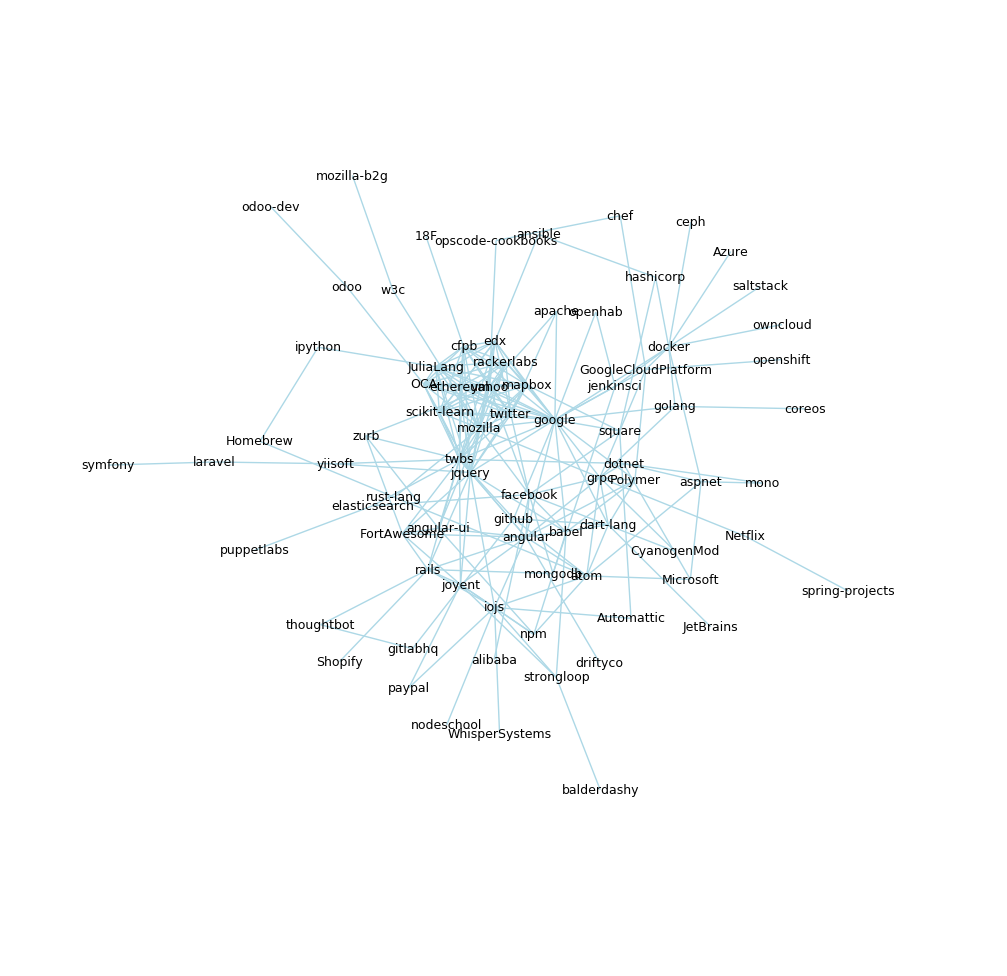

In [20]:
# add code